In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm 
plt.rcParams['animation.html'] = 'html5'

conservation of momentum 

$$
\rho \dot{\vec{u}} = - \nabla p + \mu \nabla^2 u + F
$$


continuity

$$
\nabla \cdot u = 0
$$


conservation of momentum 

$$
\rho \dot{\vec{u}} = - \nabla p + \mu \nabla^2 u + F
$$


$$ \nabla = (\frac{d}{dx}, \frac{d}{dy}) $$

$$ \nabla^2 = (\frac{d^2}{dx^2}, \frac{d^2}{dy^2}) $$

$$ \nabla^2 \cdot \vec{u} = \frac{d^2 \, u_x}{dx^2} + \frac{d^2 \, u_y}{dy^2} $$

$$ \nabla \cdot \vec{u} = \frac{d \, u_x}{dx} + \frac{d \, u_y}{dy} $$

continuity

$$
\nabla \cdot u = 0
$$



$$
a m = \sum F
$$

$$
\vec{a} m = \dot{u} \rho 
$$

$$
\rho \frac {d \, u} {d \,t} = - \nabla p + \mu \nabla^2 u + F
$$

$$
\rho \frac {d \, u} {d \,t} = \mathrm{pressure\_differential} + \mathrm{friction} + \mathrm{other\_forces}
$$

$$
    \lim_{h\to0} \frac {f(x+h) - f(x)} {h} = f'(x) \approx \frac {f(x+h) - f(x)} {h}, \quad h = 0.000001
$$

In [2]:
# Important variables and constants
lx = 1.0 # Length of the domain in meters
ly = 1.0 # Height of the domain in meters
nx = 32 # Number of nodes in the x direction
ny = 32 # Number of nodes in the y direction

x = np.linspace(0, lx, nx) # x nodes
dx = x[1] - x[0] # dx

y = np.linspace(0, ly, ny) # y nodes
dy = y[1] - y[0] # dy

xx, yy = np.meshgrid(x, y) # Meshgrid

# COnditions and flow properties
Uwall = 1.0 # Velocity at the top wall in m/s
nu = 0.05
print(f'Reynolds number: {Uwall * ly / nu}')

# Stability condition
dt1 = 0.5 / (nu * (1.0 / dx / dx + 1.0 / dy / dy))
dt2 = 2.0 * nu / (Uwall * Uwall)
dt = min(dt1, dt2)
print(f'Stable timestep size: dt = {dt} s')

# Arrays
u = np.zeros((ny, nx)) # x velocity
v = np.zeros((ny, nx)) # y velocity
p = np.zeros((ny, nx))

Reynolds number: 20.0
Stable timestep size: dt = 0.005202913631633714 s


In [ ]:
# Useful functions
# Helper to compute first and second derivatives
def ddx(_f, _dx):
    _results = np.zeros_like(_f)
    _results[1:-1, 1:-1] = (_f[1:-1, 2:] - _f[1:-1, :-2]) / 2.0 / _dx
    return _results

def ddy(_f, _dy):
    _results = np.zeros_like(_f)
    _results[1:-1, 1:-1] = (_f[2:, 1:-1] - _f[:-2, 1:-1]) / 2.0 / _dy
    return _results

def laplacian(_f, _dx, _dy):
    # This computes nabla^2 f = d^2 f / dx^2 + d^2 f / dy^2
    _results = np.zeros_like(_f)
    _results[1:-1, 1:-1] = (
        (_f[1:-1, 2:] - 2.0*_f[1:-1, 1:-1] + _f[1:-1, :-2]) / _dx / _dx
        + (_f[2:, 1:-1] - 2.0*_f[1:-1, 1:-1] + _f[2:, 1:-1]) / _dy / _dy
    )
    
    return _results

def divergence(_a, _b, _dx, _dy):
    return ddx(_a, _dx) + ddy(_b, _dy)

def poisson_solver(p, _dx, _dy, _rhs):
    # NOTE: p will be modified in place
    _tol = 1e-5 # tolerance
    _err = 100
    _maxIt = 50
    _it = 0
    _beta = 1.0
    
    while _err > _tol and _it < _maxIt:
        # top wall
        p[-1, :] = 0.0
        
        # bottom wall (Nuemann, dpdy = 0)
        p[0, :] = p[1, :]
        
        # left wall (Nuemann, dpdx = 0)
        p[:, 0] = p[:, 1]
        
        # right wall (Nueman, dpdx = 0)
        p[:, -1] = p[:, -2]
        
        pk = np.zeros_like(p)
        pk[1:-1, 1:-1] = p[1:-1, 1:-1]
        
        for i in range(1, ny-1):
            for j in range(1, nx-1):
                _rhs_copy = (
                    -(dx*dy)**2 * _rhs[j, i] 
                    + dy**2 * (p[j, i+1] + p[j, i-1]) 
                    + dx**2 * (p[j+1, i] + p[j-1, i])
                ) 
                _rhs_copy *= 1.0 / 2.0 / (dx**2 + dy**2)
                p[j, i] = _rhs_copy
                
        _err = np.linalg.norm(p.ravel() - pk.ravel())
        _it += 1
        
    return _err
        

In [4]:
# time advance
t = 0.0
epochs = 10
tend = epochs * dt

while t < tend:
    # Feedback
    print(f't = {t}')
    
    # Set the boundary conditions
    # top wall
    u[-1, :] = Uwall
    v[-1, :] = 0.0
    
    # left wall
    u[:, 0] = 0.0
    v[:, 0] = 0.0
    
    # bottom wall
    u[0, :] = 0.0
    v[0, :] = 0.0
    
    # right wall
    u[:, -1] = 0.0
    v[:, -1] = 0.0
    
    # x-momentum - RHS
    # Cux = ddx(u*u, dx)
    # Cuy = ddy(v*u, dy)
    # Cvx = ddx(u*v, dx)
    # Cvy = ddy(v*v, dy)
    
    uRHS = -ddx(u*u, dx) - ddy(v*u, dy) + nu * laplacian(u, dx, dy)
    vRHS = -ddx(u*v, dx) - ddy(v*v, dy) + nu * laplacian(v, dx, dy)
    
    # Compute incomplete velocity
    ut = u + dt*uRHS
    vt = v + dt*vRHS
    
    # Build the pressure poisson equation
    prhs = divergence(u, v, dx, dy)/dt + divergence(uRHS, vRHS, dx, dy)
    
    err = poisson_solver(p, dx, dy, prhs) # now we have the pressure
    dpdx = ddx(p, dx)
    dpdy = ddy(p, dy)
    
    # Time update
    u = u + dt*uRHS - dt*dpdx
    v = v + dt*vRHS - dt*dpdy
    
    # Foward time
    t += dt
    
    # vel = np.sqrt(u**2 + v**2)
    # plt.streamplot(xx, yy, u, v, color=vel, linewidth=2, cmap=cm.coolwarm)
    # plt.show()

t = 0.0
t = 0.005202913631633714
t = 0.010405827263267428
t = 0.015608740894901142
t = 0.020811654526534856
t = 0.02601456815816857
t = 0.031217481789802284
t = 0.036420395421436
t = 0.04162330905306971
t = 0.04682622268470343


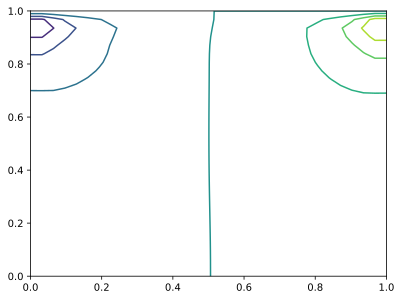

In [5]:
plt.contour(xx, yy, p)

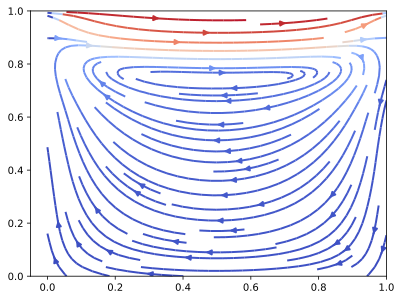

In [6]:
vel = np.sqrt(u**2 + v**2)
plt.streamplot(xx, yy, u, v, color=vel, linewidth=2, cmap=cm.coolwarm)

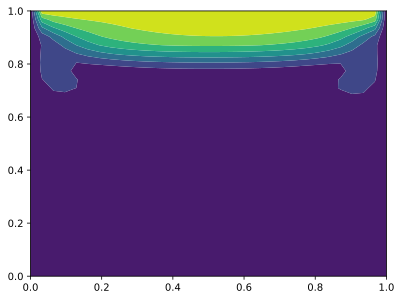

In [7]:
plt.contourf(xx, yy, vel)

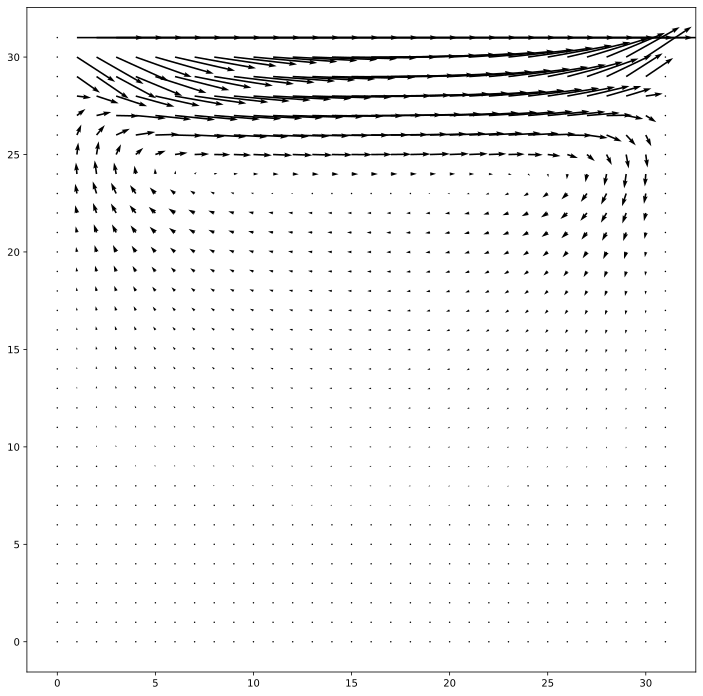

In [8]:
# size
plt.figure(figsize=(12, 12))
# arrow size
scale = 10.0
# plot the velocity field

plt.quiver(u, v, scale=scale)